In [1]:
DEBUG = True
N_DEBUG = 10
USE_CACHE = False

In [2]:
import pandas as pd
import numpy as np
import transformers
import torch
import re
from tqdm import tqdm
import sklearn
# import spacy
# nlp = spacy.load("en_core_web_sm")

In [3]:
test = pd.read_pickle("./dataset_test.pkl")


documents = test["answer"]
gold_labels = test["author"] == "human_answers" # convention: 0: machine, 1: human, see detector.py

if DEBUG and N_DEBUG > 0:
    documents = documents[0:N_DEBUG]
    gold_labels = gold_labels[0:N_DEBUG]



from gpt2outputdataset.detector_radford import DetectorRadford
from detectgpt.detector_detectgpt import DetectorDetectGPT
from detector_guo import DetectorGuo
detector_classes = [DetectorRadford, DetectorGuo]

from explainer_wrappers import LIME_Explainer, SHAP_Explainer, Random_Explainer
explainer_classes = [LIME_Explainer, SHAP_Explainer]

In [4]:
from abc import ABC, abstractmethod
class Experiment(ABC):
    @abstractmethod 
    def __init__(self, explainer, document, gt):
        self.document = document
        self.gt = gt
        self.explainer = explainer
        self.fi_scores_machine  = self.explainer.get_fi_scores(document, fill=True)[0]
        self.fi_scores_human = self.explainer.get_fi_scores(document, fill=True)[1]
    @property
    @abstractmethod
    def modified_document(self):
        pass
    # as in Arras et al. 2016: "The target class is the true document class,[...]"
    def get_fi_scores_target(self):
        if self.gt:
            return self.fi_scores_human
        else:
            return self.fi_scores_machine
    def remove_features(self, id_fi_tuples_list, mask=True):
        tokenized_modified_document = self.explainer.tokenize(self.document)

        # two asserts to verify that approach is valid
       # print("r",expself.explainerlainer.untokenize(self.explainer.tokenize(self.document, collapse_whitespace=False)))
       # print("o", self.document)
        # this fails: 
        # assert self.explainer.untokenize(self.explainer.tokenize(self.document, collapse_whitespace=False)) == self.document, "Merging strategy faulty"
        # see self.explainer.LIME_Explainer.untokenize
       
        ### assert right words are removed
        top_words = [word for word, fi in self.explainer.as_list(self.explainer.get_explanation_cached(self.document), label=self.gt) if fi > 0]
        for a, b in zip(tokenized_modified_document, self.explainer.tokenize(self.document)):
            if a == self.explainer.detector.get_pad_token():
                assert b in top_words, "Masking strategy faulty"
        ###
       
        ids_tokens_to_remove = []
        # don't remove anything if there are no best/worst features (e.g. only positive or only negative fi scores)
        if len(id_fi_tuples_list):
            ids_tokens_to_remove, _ = zip(*id_fi_tuples_list) 
        # replace with pad token (all detectors support partial input)
        if mask:
            for t in ids_tokens_to_remove:
                tokenized_modified_document[t] = self.explainer.detector.get_pad_token()
        else:
            tokenized_modified_document = [t for i, t in enumerate(tokenized_modified_document) if i not in ids_tokens_to_remove]
        return self.explainer.untokenize(tokenized_modified_document)

In [5]:
class Experiment_Delete_n_Highest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):
        if self.n == 0:
            return self.document
        highest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=True)[0:self.n]
        # remove 0 scores if !include_zero_scores
        highest_fi_scores_target = [(idx, fi) for idx,fi in highest_fi_scores_target if self.include_zero_scores or (fi != 0)]

        return self.remove_features(highest_fi_scores_target, mask=self.mask)


In [6]:
class Experiment_Delete_n_Lowest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):
        lowest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=False)[0:self.n]
        # remove 0 scores if !include_zero_scores
        lowest_fi_scores_target = [(idx, fi) for idx,fi in lowest_fi_scores_target if self.include_zero_scores or (fi != 0)]
        return self.remove_features(lowest_fi_scores_target, mask=self.mask)


In [7]:
class Experiment_Delete_all_except_n_Highest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):
        all_but_highest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=True)[self.n:]
        all_but_highest_fi_scores_target = [(idx, fi) for idx,fi in all_but_highest_fi_scores_target if self.include_zero_scores or (fi != 0)]
        return self.remove_features(all_but_highest_fi_scores_target, mask=self.mask)

In [8]:
class Experiment_Delete_all_except_n_Lowest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):

        all_but_lowest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=False)[self.n:]
        all_but_lowest_fi_scores_target = [(idx, fi) for idx,fi in all_but_lowest_fi_scores_target if self.include_zero_scores or (fi != 0)]
        return self.remove_features(all_but_lowest_fi_scores_target, mask=self.mask)

In [9]:
prediction_cache = {}
def prediction_cached(detector, document):
    id = (detector.__class__.__name__,document)
    if id not in prediction_cache:
        prediction_cache[id] = detector.predict_proba([document])[0]
    return prediction_cache[id]


In [10]:
def get_results_row(document, gt,  explainer, experiment_class, detector, n, mask):
    
    experiment = experiment_class(explainer, document, gt, n=n, mask=mask)
    p_machine_original, p_human_original  = prediction_cached(detector, experiment.document)
    y_original = p_human_original >= p_machine_original

    p_machine_modified = None
    p_human_modified = None
    if n == 0:
        assert experiment.modified_document == experiment.document # just a sanity check for the experiment classes
        p_machine_modified, p_human_modified = prediction_cached(detector, experiment.modified_document)
    else:
        p_machine_modified, p_human_modified = prediction_cached(detector, experiment.modified_document)
   # print(explainer.seed, experiment.modified_document)
    y_modified = p_human_modified >= p_machine_modified
    return [
                    explainer.__class__.__name__, 
                    explainer.detector.__class__.__name__, 
                    n,
                    p_machine_original,
                    p_human_original,
                    y_original,
                    p_machine_modified,
                    p_human_modified,
                    y_modified,
                    gt]

In [11]:
def run_experiment(experiment_class, detector, n=10, mask=True):
    results = []
    columns=["Explainer", "Detector", "n", "p_machine_original", "p_human_original", "y_original", "p_machine_modified", "p_human_modified", "y_modified", "gt"]
    
    for explainer_class in explainer_classes:
        explainer = explainer_class(detector)
        if isinstance(explainer, LIME_Explainer) and n > explainer.num_features:
            print("skip lime",n, explainer.num_features)
            continue
        for document, gt in zip(documents, gold_labels):
            results.append(get_results_row(document, gt, explainer, experiment_class, detector, n, mask))

    # random baseline (with new seeds at each run)
    for i in range(0,10):
        random_explainer = Random_Explainer(detector, seed=42-i)
        for document, gt in zip(documents, gold_labels):
            results_row = get_results_row(document, gt, random_explainer, experiment_class, detector, n, mask)
            results_row[0] = "Random Run "+str(i)
            results.append(results_row)

    df = pd.DataFrame(results, columns=columns)

    df["p_target_original"] = df.apply(lambda x: x["p_human_original"] if x["gt"] else x["p_machine_original"], axis=1)
    df["p_target_modified"] = df.apply(lambda x: x["p_human_modified"] if x["gt"] else x["p_machine_modified"], axis=1)    
    df["drop_target"] = df["p_target_original"] - df["p_target_modified"] 

    

    return df

In [12]:
import matplotlib.pyplot as plt

## Plot like in Arras et al.

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
def get_acc_by_initial_prediction_right_wrong(df, n, mask):
    accs = []
    for explainer_name, group in df.groupby("Explainer"):
        group_initial_right = group[group["y_original"] == group["gt"]]
        group_initial_wrong = group[group["y_original"] != group["gt"]]
        accs.append((explainer_name,accuracy_score(group_initial_right["gt"], group_initial_right["y_modified"]), accuracy_score(group_initial_wrong["gt"], group_initial_wrong["y_modified"]),n, mask))
    return pd.DataFrame(accs, columns=["Explainer", "acc_initial_right", "acc_initial_wrong", "n", "mask"])

In [15]:
import seaborn as sns
import os

In [16]:
results_path = "./token_removal_experiments_results"

In [17]:
n_deleted_words = list(range(0,10+1)) + [20,30,40,50]


for detector_class in detector_classes:
    
    detector = detector_class()
    path = os.path.join(results_path, detector.__class__.__name__+".csv")
    if USE_CACHE and os.path.isfile(path):
        continue

    dfs_at_n_mask = [(run_experiment(Experiment_Delete_n_Highest,detector, n=n, mask=True), n, True) for n in tqdm(n_deleted_words, desc="Running mask experiment for "+detector.__class__.__name__)]
    dfs_at_n_delete = [(run_experiment(Experiment_Delete_n_Highest,detector, mask=False, n=n), n, False) for n in tqdm(n_deleted_words, desc="Running delete experiment for "+detector.__class__.__name__)]
    dfs_at_n = dfs_at_n_mask + dfs_at_n_delete
    df_accuracy_scores = pd.concat([get_acc_by_initial_prediction_right_wrong(df,n, mask) for df, n, mask in dfs_at_n])
    
    df_accuracy_scores.loc[df_accuracy_scores["Explainer"].str.startswith("Random"), "Explainer"] = "Random"
    # df_accuracy_scores.groupby(["Explainer", "n"]).mean().reset_index()

    df_accuracy_scores["Explainer"] = df_accuracy_scores["Explainer"].str.replace("_Explainer","")
    df_accuracy_scores["Detector"] = detector.__class__.__name__
    
    df_accuracy_scores.to_csv(path, encoding="UTF-8", index=False)


Running experiment for DetectorRadford:  73%|███████▎  | 11/15 [00:32<00:11,  2.98s/it]

skip lime 20 10


Running experiment for DetectorRadford:  80%|████████  | 12/15 [00:34<00:08,  2.92s/it]

skip lime 30 10


Running experiment for DetectorRadford:  87%|████████▋ | 13/15 [00:37<00:05,  2.90s/it]

skip lime 40 10


Running experiment for DetectorRadford:  93%|█████████▎| 14/15 [00:40<00:02,  2.91s/it]

skip lime 50 10


Running experiment for DetectorRadford: 100%|██████████| 15/15 [00:43<00:00,  2.92s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Running experiment for DetectorGuo:  73%|███████▎  | 11/15 [00:28<00:11,  2.79s/it]

skip lime 20 10


Running experiment for DetectorGuo:  80%|████████  | 12/15 [00:31<00:08,  2.78s/it]

skip lime 30 10


Running experiment for DetectorGuo:  87%|████████▋ | 13/15 [00:33<00:05,  2.81s/it]

skip lime 40 10


Running experiment for DetectorGuo:  93%|█████████▎| 14/15 [00:36<00:02,  2.77s/it]

skip lime 50 10


Running experiment for DetectorGuo: 100%|██████████| 15/15 [00:39<00:00,  2.63s/it]


,Explainer,acc_initial_right,acc_initial_wrong,n,Detector
0,LIME,1.000000,0.0,0,DetectorGuo
1,Random,1.000000,0.0,0,DetectorGuo
2,Random,1.000000,0.0,0,DetectorGuo
3,Random,1.000000,0.0,0,DetectorGuo
4,Random,1.000000,0.0,0,DetectorGuo
...,...,...,...,...,...
171,Random,0.777778,1.0,50,DetectorGuo
172,Random,0.777778,1.0,50,DetectorGuo
173,Random,0.777778,1.0,50,DetectorGuo
174,Random,0.777778,1.0,50,DetectorGuo


,Explainer,acc_initial_right,acc_initial_wrong,n,Detector
0,LIME,1.000000,0.0,0,DetectorRadford
1,Random,1.000000,0.0,0,DetectorRadford
2,Random,1.000000,0.0,0,DetectorRadford
3,Random,1.000000,0.0,0,DetectorRadford
4,Random,1.000000,0.0,0,DetectorRadford
...,...,...,...,...,...
171,Random,0.555556,0.0,50,DetectorRadford
172,Random,0.555556,1.0,50,DetectorRadford
173,Random,0.555556,1.0,50,DetectorRadford
174,Random,0.444444,1.0,50,DetectorRadford


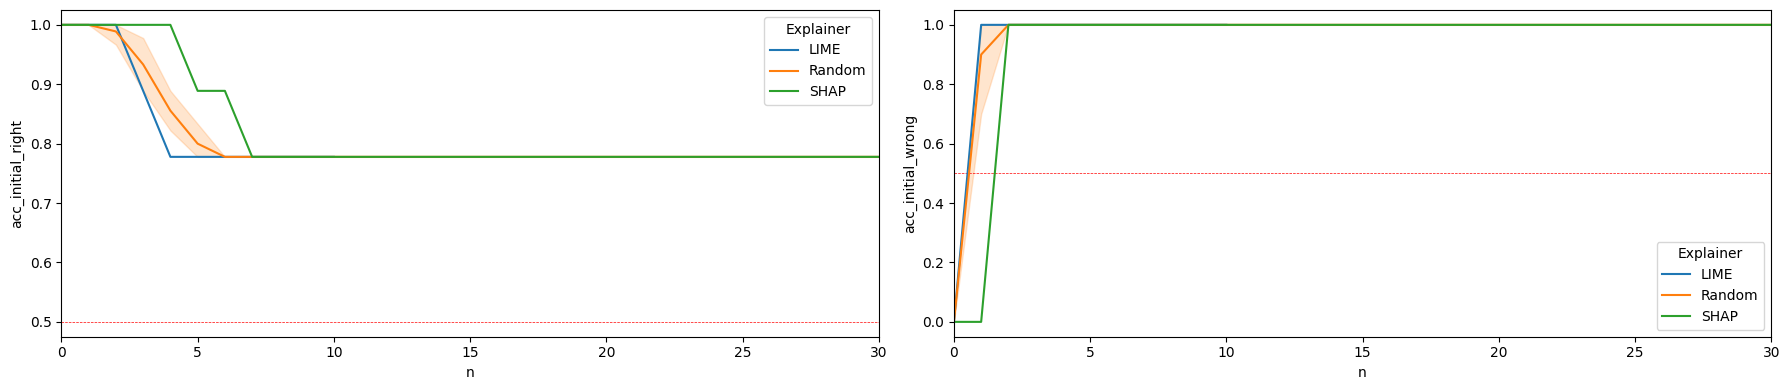

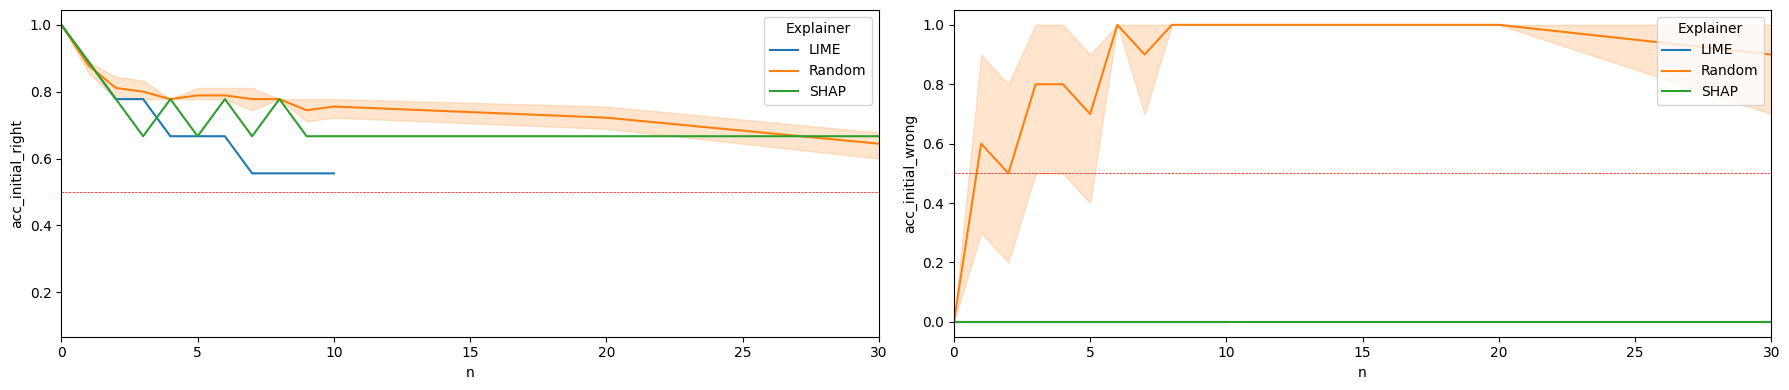

In [18]:
for f in os.listdir(results_path):
    detector_name = f.split(".")[0]
    df_accuracy_scores = pd.read_csv(os.path.join(results_path, f))
    #df_accuracy_scores = df_accuracy_scores[df_accuracy_scores["Explainer"] == "Random"]
    display(df_accuracy_scores)
    f, (ax_right, ax_wrong) = plt.subplots(1,2, sharey=False, figsize=(18,4))
    ax_right.axhline(y=0.5,linestyle='--', lw=0.5, color="red")
    ax_wrong.axhline(y=0.5,linestyle='--', lw=0.5, color="red")

    sns.lineplot(data=df_accuracy_scores, x="n", y="acc_initial_right", hue="Explainer", ax=ax_right)
    sns.lineplot(data=df_accuracy_scores, x="n", y="acc_initial_wrong", hue="Explainer", ax=ax_wrong)
    ax_wrong.set_xlim(0,30)
    ax_right.set_xlim(0,30)
    f.tight_layout()

In [19]:
df_accuracy_scores[df_accuracy_scores["Explainer"] == "Random"].groupby("n").describe()

acc_initial_right                                                    \
               count      mean       std       min       25%       50%   
n                                                                        
0               10.0  1.000000  0.000000  1.000000  1.000000  1.000000   
1               10.0  0.877778  0.035136  0.777778  0.888889  0.888889   
2               10.0  0.811111  0.053672  0.777778  0.777778  0.777778   
3               10.0  0.800000  0.046849  0.777778  0.777778  0.777778   
4               10.0  0.777778  0.000000  0.777778  0.777778  0.777778   
5               10.0  0.788889  0.035136  0.777778  0.777778  0.777778   
6               10.0  0.788889  0.035136  0.777778  0.777778  0.777778   
7               10.0  0.777778  0.052378  0.666667  0.777778  0.777778   
8               10.0  0.777778  0.000000  0.777778  0.777778  0.777778   
9               10.0  0.744444  0.053672  0.666667  0.694444  0.777778   
10              10.0  0.755556  0.046849  0.666667  0.777778  0.777778   
20              10.0  0.722222  0.058561  0.666667  0.666667  0.722222   
30              10.0  0.644444  0.070273  0.555556  0.583333  0.666667   
40              10.0  0.588889  0.091475  0.444444  0.555556  0.555556   
50              10.0  0.522222  0.053672  0.444444  0.472222  0.555556   

                       acc_initial_wrong                                      \
         75%       max             count mean       std  min   25%  50%  75%   
n                                                                              
0   1.000000  1.000000              10.0  0.0  0.000000  0.0  0.00  0.0  0.0   
1   0.888889  0.888889              10.0  0.6  0.516398  0.0  0.00  1.0  1.0   
2   0.861111  0.888889              10.0  0.5  0.527046  0.0  0.00  0.5  1.0   
3   0.777778  0.888889              10.0  0.8  0.421637  0.0  1.00  1.0  1.0   
4   0.777778  0.777778              10.0  0.8  0.421637  0.0  1.00  1.0  1.0   
5   0.777778  0.888889              10.0  0.7  0.483046  0.0  0.25  1.0  1.0   
6   0.777778  0.888889              10.0  1.0  0.000000  1.0  1.00  1.0  1.0   
7   0.777778  0.888889              10.0  0.9  0.316228  0.0  1.00  1.0  1.0   
8   0.777778  0.777778              10.0  1.0  0.000000  1.0  1.00  1.0  1.0   
9   0.777778  0.777778              10.0  1.0  0.000000  1.0  1.00  1.0  1.0   
10  0.777778  0.777778              10.0  1.0  0.000000  1.0  1.00  1.0  1.0   
20  0.777778  0.777778              10.0  1.0  0.000000  1.0  1.00  1.0  1.0   
30  0.666667  0.777778              10.0  0.9  0.316228  0.0  1.00  1.0  1.0   
40  0.638889  0.777778              10.0  0.8  0.421637  0.0  1.00  1.0  1.0   
50  0.555556  0.555556              10.0  0.6  0.516398  0.0  0.00  1.0  1.0   

         
    max  
n        
0   0.0  
1   1.0  
2   1.0  
3   1.0  
4   1.0  
5   1.0  
6   1.0  
7   1.0  
8   1.0  
9   1.0  
10  1.0  
20  1.0  
30  1.0  
40  1.0  
50  1.0

In [20]:
f, (ax_right, ax_wrong) = plt.subplots(1,2, sharey=True, figsize=(5,2))
    sns.lineplot(data=df_accuracy_scores, x="n", y="acc_initial_right", hue="Explainer", ax=ax_right)
    sns.lineplot(data=df_accuracy_scores, x="n", y="acc_initial_wrong", hue="Explainer", ax=ax_wrong)


IndentationError: unexpected indent (3621167548.py, line 2)

In [ ]:
dfs_at_n = [(run_experiment(Experiment_Delete_n_Highest,detector, n=n), n) for n in tqdm(n_deleted_words, desc="Running experiment with different n")]
df_accuracy_scores = pd.concat([get_acc_by_initial_prediction_right_wrong(df,n) for df, n in dfs_at_n])

df_accuracy_scores.loc[df_accuracy_scores["Explainer"].str.startswith("Random"), "Explainer"] = "Random"
# df_accuracy_scores.groupby(["Explainer", "n"]).mean().reset_index()

df_accuracy_scores["Explainer"] = df_accuracy_scores["Explainer"].str.replace("_Explainer","")
display(df_accuracy_scores)

Running experiment with different n: 100%|██████████| 15/15 [20:56<00:00, 83.73s/it]


,Explainer,acc_initial_right,acc_initial_wrong,n
0,LIME,1.000000,0.0,0
1,Random,1.000000,0.0,0
2,Random,1.000000,0.0,0
3,Random,1.000000,0.0,0
4,Random,1.000000,0.0,0
...,...,...,...,...
7,Random,0.493377,1.0,50
8,Random,0.493377,1.0,50
9,Random,0.493377,1.0,50
10,Random,0.493377,1.0,50


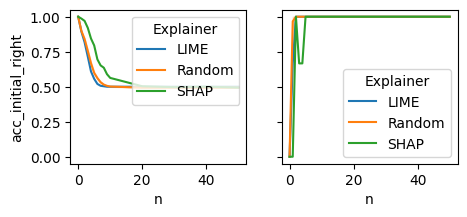

In [ ]:

f, (ax_right, ax_wrong) = plt.subplots(1,2, sharey=True, figsize=(5,2))
sns.lineplot(data=df_accuracy_scores, x="n", y="acc_initial_right", hue="Explainer", ax=ax_right)
sns.lineplot(data=df_accuracy_scores, x="n", y="acc_initial_wrong", hue="Explainer", ax=ax_wrong)

# random baseline

plt.show()

In [ ]:


acc_scores = [(accuracy_score(df["gt"], df["y_modified"]),n) for df, n in dfs_at_n] # @ 0 removed + n removed
acc_scores

[(0.9901639344262295, 0),
 (0.9049180327868852, 1),
 (0.8508196721311475, 2),
 (0.7680327868852459, 3),
 (0.6800546448087431, 4),
 (0.6150273224043716, 5),
 (0.5734972677595629, 6),
 (0.5445355191256831, 7),
 (0.5289617486338798, 8),
 (0.5174863387978142, 9),
 (0.5112021857923498, 10),
 (0.4997267759562842, 20),
 (0.49918032786885247, 30),
 (0.4994535519125683, 40),
 (0.4989071038251366, 50)]

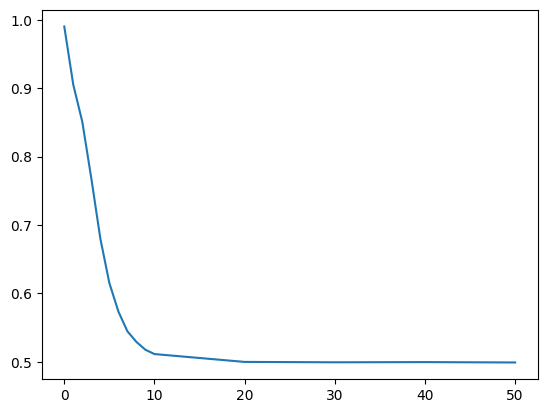

In [ ]:
acc, n = zip(*acc_scores)
plt.plot(n, acc)

In [ ]:
def run_experiment_incremental(experiment_class, start = 0, stop = 30):
    dfs = [run_experiment(experiment_class, n=n) for n in tqdm(range(start,stop+1), desc="Running {}".format(experiment_class.__name__))]
    df = pd.concat(dfs)
    df["drop_target"] = df["p_target_original"] - df["p_target_modified"]

    for name, group in df.groupby(["Explainer", "Detector", ]):
        print(name)
        group.reset_index()[["n", "drop_target"]].groupby("n").mean().plot()
        plt.show()

    

In [ ]:
# # Experiment_Delete_n_Highest: higher drop_target is better
# df = run_experiment(Experiment_Delete_n_Highest)
# df["drop_target"] = df["p_target_original"] - df["p_target_modified"]
# df.groupby(["Explainer", "Detector"]).mean()

In [ ]:
# Experiment_Delete_n_Highest: higher drop_target is better

run_experiment_incremental(Experiment_Delete_n_Highest)


Running Experiment_Delete_n_Highest:   0%|          | 0/31 [00:00<?, ?it/s]

TypeError: run_experiment() missing 1 required positional argument: 'detector'

In [ ]:
# Experiment_Delete_n_Lowest: smaller drop_target is better
run_experiment_incremental(Experiment_Delete_n_Lowest)


In [ ]:
# Experiment_Delete_all_except_n_Highest: smaller drop_target is better
run_experiment_incremental(Experiment_Delete_all_except_n_Highest)


In [ ]:
# Experiment_Delete_all_except_n_Lowest: higher drop_target is better
run_experiment_incremental(Experiment_Delete_all_except_n_Lowest)